In [2]:
import torch                           # Pytorch
import torch.autograd as autograd      # computation graph
from torch import Tensor               
import torch.nn as nn                  # neural networks
import torch.optim as optim            # optimizers 

import matplotlib
matplotlib.rcParams['font.family'] = 'serif'

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook

# Set default dtype to float32
torch.set_default_dtype(torch.float)

# PyTorch random number generator
torch.manual_seed(12345678)

# Random number generators in numpy
np.random.seed(12345678)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cgpu')

print("The neural network will be trainied on", device)

if device == torch.device('cuda'): 
    print(torch.cuda.get_device_name(0))

The neural network will be trainied on cuda
NVIDIA GeForce RTX 3090


In [3]:
# Define the simulation parameters
x_min=0
x_max=2

t_min=0
t_max=0.48

viscosity = 0.01/np.pi

# Discretization points for x and t

N_x=1001
N_t=2000

dx = (x_max-x_min)/(N_x-1)

dt = (t_max-t_min)/(N_t)

print("dx =", dx, "dt =", dt)

dx = 0.002 dt = 0.00023999999999999998


In [4]:
# Define the 1D grid and initial condition of u
x = np.linspace(x_min, x_max, N_x)
u = np.sin(np.pi * x)

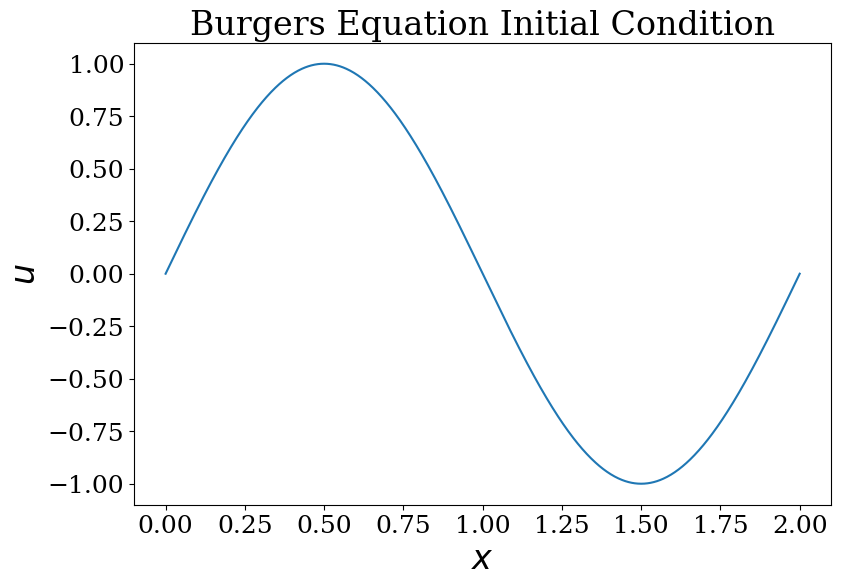

In [5]:
labelsize = 24
ticksize = 18

u_init = u.copy()
plt.figure(figsize=(9, 6))
plt.plot(x, u_init)
plt.xlabel('$x$', fontsize=labelsize)
plt.ylabel('$u$', fontsize=labelsize)
plt.title('Burgers Equation Initial Condition', fontsize=labelsize)
plt.xticks(fontsize=ticksize);
plt.yticks(fontsize=ticksize);
# plt.savefig('burgers_ic.png', dpi=300, bbox_inches='tight')

In [6]:
def finite_diff(u, x, dt):
    un = u.copy()
    un = u - u * dt * (np.roll(u, -1, 0) - np.roll(u, 1, 0)) / dx / 2.0 + viscosity * (dt/dx**2) * (np.roll(u, -1, 0) - 2*u + np.roll(u, 1, 0))
    return un

# Store the finite difference results at every time step
fd_results = torch.zeros([N_x, N_t])

for i in tqdm_notebook(range(N_t)):
    u = finite_diff(u, x, dt)
    fd_results[:,i] = torch.tensor(u)
    if np.isnan(u).any():
        print(i, dt * i)
        break

u_final = u

  0%|          | 0/2000 [00:00<?, ?it/s]

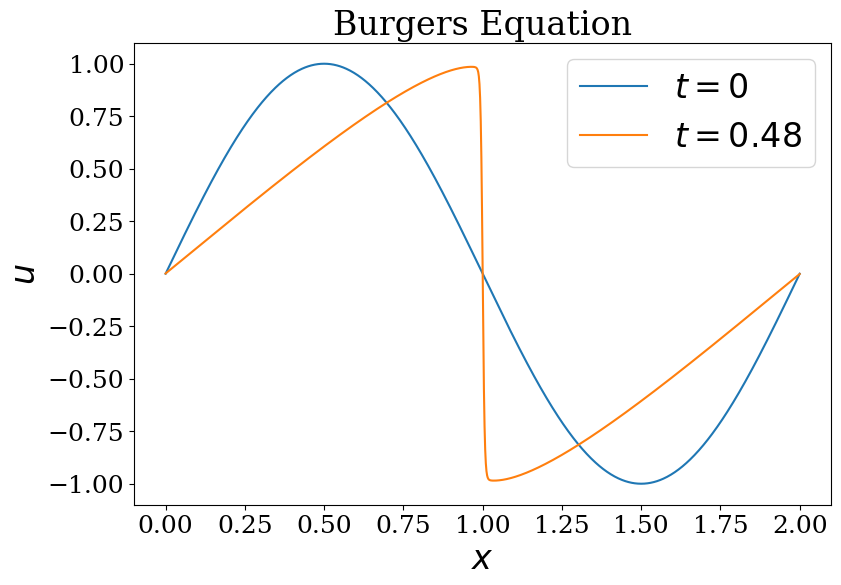

In [7]:
plt.figure(figsize=(9, 6))
plt.plot(x, u_init, label=f"$t = {t_min}$")
plt.plot(x, u_final, label=f"$t = {t_max}$")
plt.xlabel('$x$', fontsize=labelsize)
plt.ylabel('$u$', fontsize=labelsize)
plt.title('Burgers Equation', fontsize=labelsize)
plt.xticks(fontsize=ticksize);
plt.yticks(fontsize=ticksize);
plt.legend(fontsize=labelsize)
# plt.savefig('burgers_result_fd.png', dpi=300, bbox_inches='tight')

In [8]:
# Creating same grid as finite difference method
xs = torch.linspace(x_min, x_max, N_x).view(-1,1)
ts = torch.linspace(t_min, t_max, N_t).view(-1,1)
print(xs.shape, ts.shape)
X, T = torch.meshgrid(xs.squeeze(1),ts.squeeze(1), indexing='ij') # same as finite difference
print(X.shape, T.shape)

torch.Size([1001, 1]) torch.Size([2000, 1])
torch.Size([1001, 2000]) torch.Size([1001, 2000])


In [9]:
left_X = torch.hstack((X[:,0][:,None], T[:,0][:,None])) #horizontal stacking to create X, T dataset
left_U = torch.sin(np.pi * left_X[:,0]).unsqueeze(1) #initial condition is a sine wave
left_U.shape

torch.Size([1001, 1])

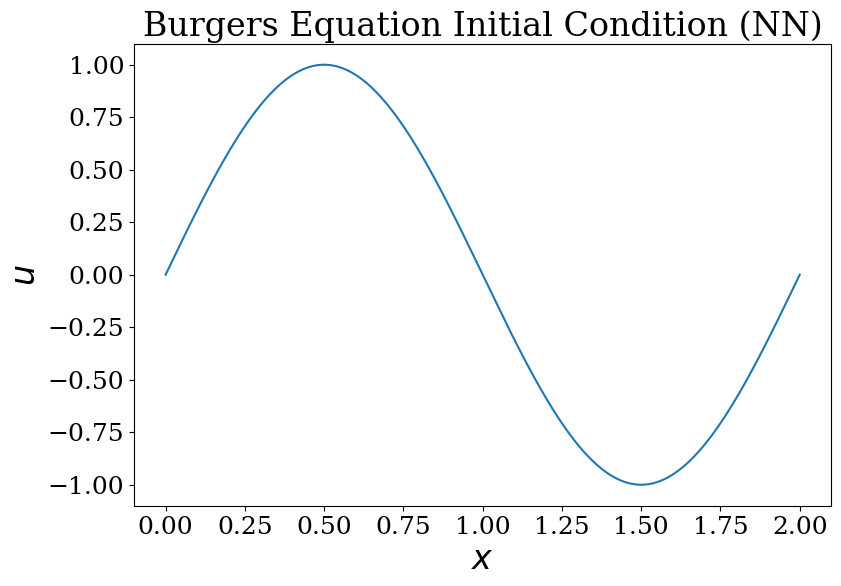

In [10]:
plt.figure(figsize=(9, 6))
plt.plot(x, left_U)
plt.xlabel('$x$', fontsize=labelsize)
plt.ylabel('$u$', fontsize=labelsize)
plt.title('Burgers Equation Initial Condition (NN)', fontsize=labelsize)
plt.xticks(fontsize=ticksize);
plt.yticks(fontsize=ticksize);

In [11]:
# BC at x_min
bottom_X = torch.hstack((X[0,:][:,None],T[0,:][:,None]))
top_X = torch.hstack((X[-1,:][:,None],T[-1,:][:,None]))

bottom_U = torch.zeros(bottom_X.shape[0],1)
top_U = torch.zeros(top_X.shape[0],1)

print(bottom_X.shape)

X_bc = torch.vstack([bottom_X, top_X])
U_bc = torch.vstack([bottom_U, top_U])

print(X_bc.shape)

torch.Size([2000, 2])
torch.Size([4000, 2])


In [12]:
N_ic = 1000
N_bc = 1000 #Number of points on IC and BC
N_pde = 30000 #Number of points on PDE domain (Collocation Points)

#Now we will sample N_bc points at random 
#from the X_train, U_train dataset

idx = np.random.choice(X_bc.shape[0],N_bc, replace=False)
X_bc_samples = X_bc[idx,:]
U_bc_samples = U_bc[idx,:]

idx = np.random.choice(left_X.shape[0],N_ic, replace=False)
X_ic_samples = left_X[idx,:]
U_ic_samples = left_U[idx,:]

#The boundary conditions will not change. 
#Hence, these U values can be used as supervised labels during training

#For PDE collocation points, we will generate new X_train_pde dataset
#We do not know U(X,T) for these points 

#Lets get the entire X,T dataset in a format suitable for Neural Network
#We will later use this for testing NN as well. So, lets call this x_test for convenience

x_test = torch.hstack((X.transpose(1,0).flatten()[:,None],
                       T.transpose(1,0).flatten()[:,None]))

#We need column major flattening to simlulte time-marching. Hence the transpose(1,0) or simply use .T

#we will use U generated from FEM as our u_test 
#We will use u_test later in the process for calculating NN performance 

u_test = fd_results.transpose(1,0).flatten()[:,None]
x_test.shape

torch.Size([2002000, 2])

In [13]:
lb = x_test[0]
ub = x_test[-1]
lb,ub

(tensor([0., 0.]), tensor([2.0000, 0.4800]))

In [14]:
#Sampling (X,T) domain for PDE collocation points
lhs_samples = np.random.random((N_pde,2)) 
#2 since there are 2 variables in X_train, [x,t]
lhs_samples.shape

(30000, 2)

In [15]:
X_train_lhs = lb + (ub-lb)*lhs_samples
X_train_lhs.shape

/tmp/ipykernel_182378/2618773875.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  X_train_lhs = lb + (ub-lb)*lhs_samples


torch.Size([30000, 2])

In [16]:
X_train_final = torch.vstack((X_train_lhs, X_ic_samples, X_bc_samples))
X_train_final.shape

torch.Size([32000, 2])

In [17]:
#Lets define a u_NN

class u_NN(nn.Module):
    
    def __init__(self, layers_list):
        
        super().__init__()

        self.depth = len(layers_list)

        self.loss_function = nn.MSELoss(reduction="mean")
    
        self.activation = nn.Tanh() #This is important, ReLU wont work

        self.linears = nn.ModuleList([nn.Linear(layers_list[i],layers_list[i+1]) for i in range(self.depth-1)])

        for i in range(self.depth-1):
      
          nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0) #xavier normalization of weights
      
          nn.init.zeros_(self.linears[i].bias.data) #all biases set to zero 

    def Convert(self, x): #helper function
        
        if torch.is_tensor(x) !=True:
            x = torch.from_numpy(x)
        return x.float().to(device)
  
    def forward(self, x):
        
        a = self.Convert(x)

        for i in range(self.depth-2):
            z = self.linears[i](a)
            a = self.activation(z)
        
        a = self.linears[-1](a)

        return a

    def loss_bc(self, x_bc, u_bc):
        #This is similar to a Supervised Learning

        l_bc = self.loss_function(self.forward(self.Convert(x_bc)), self.Convert(u_bc)) #L2 loss

        return l_bc

    def loss_ic(self, x_ic, u_ic):
        #This is similar to a Supervised Learning

        l_ic = self.loss_function(self.forward(self.Convert(x_ic)), self.Convert(u_ic)) #L2 loss

        return l_ic

    def loss_pde(self, x_pde):
        # We will pass x_train_final here. 
        # Note that we do not have U_pde (labels) here to calculate loss. This is not Supervised Learning. 
        # Here we want to minimize the residues. So, we will first calculate the residue and then minimize it to be close to zero.

        x_pde = self.Convert(x_pde)

        x_pde_clone = x_pde.clone() ##VERY IMPORTANT
    
        x_pde_clone.requires_grad = True #enable Auto Differentiation

        NN = self.forward(x_pde_clone) #Generates predictions from u_NN

        NNx_NNt = torch.autograd.grad(NN, x_pde_clone,self.Convert(torch.ones([x_pde_clone.shape[0],1])),retain_graph=True, create_graph=True)[0] #Jacobian of dx and dt

        NNxx_NNtt = torch.autograd.grad(NNx_NNt,x_pde_clone, self.Convert(torch.ones(x_pde_clone.shape)), create_graph=True)[0] #Jacobian of dx2, dt2

        NNxx = NNxx_NNtt[:,[0]] #Extract only dx2 terms

        NNt = NNx_NNt[:,[1]] #Extract only dt terms

        NNx = NNx_NNt[:,[0]] #Extract only dx terms
    
        # {(du/dt) = viscosity * (d2u/dx2)} is the pde and the NN residue will be {du_NN/dt - viscosity*(d2u_NN)/dx2} which is == {NNt - viscosity*NNxx}

        residue = NNt + self.forward(x_pde_clone)*(NNx) - (viscosity)*NNxx 

        # The residues need to be zero (or as low as possible). We'll create an arrazy of Zeros and minimize the residue 

        zeros = self.Convert(torch.zeros(residue.shape[0],1))

        l_pde = self.loss_function(residue, zeros) #L2 Loss

        return l_pde
    
    def total_loss(self, x_ic, u_ic, x_bc, u_bc, x_pde): #Combine both loss
        l_bc = self.loss_bc(x_bc, u_bc)
        l_ic = self.loss_ic(x_ic, u_ic)
        l_pde = self.loss_pde(x_pde)
        return l_bc + l_pde + l_ic #this HAS to be a scalar value for auto differentiation to do its thing.


In [18]:
#Parameters for u_NN

EPOCHS = 30000
initial_lr = 0.001
layers_list = [2, 32, 64, 64, 32, 1]
#batch_size = 32

# Instantiate a model

PINN = u_NN(layers_list).to(device)
print(PINN)

optimizer = torch.optim.Adam(PINN.parameters(), lr=initial_lr,amsgrad=False)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.985)

history = pd.DataFrame(columns=["Epochs","Learning_Rate", "IC_Loss","BC_Loss","PDE_Loss","Total_Loss","Test_Loss"])

u_NN(
  (loss_function): MSELoss()
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [19]:
#****** Training ******#

print("Training Physics Informed Neural Network...")

Epoch = []
Learning_Rate = []
IC_Loss = []
BC_Loss = []
PDE_Loss = []
Total_Loss = []
Test_Loss = []

for i in tqdm_notebook(range(EPOCHS)):
    if i==0:
        print("Epoch \t Learning_Rate \t IC_Loss \t BC_Loss \t PDE_Loss \t Total_Loss \t Test_Loss")
        
    l_ic = PINN.loss_ic(X_ic_samples,U_ic_samples)
    l_bc = PINN.loss_bc(X_bc_samples,U_bc_samples)
    l_pde = PINN.loss_pde(X_train_final)
    loss = PINN.total_loss(X_ic_samples,U_ic_samples,X_bc_samples,U_bc_samples, X_train_final)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    if i%100 == 0: #print losses and step the exponential learning rate.
                
        with torch.no_grad():
            test_loss = PINN.loss_bc(x_test,u_test) #Here we are using loss_bc method as a helper function to calculate L2 loss
            
            Epoch.append(i)
            Learning_Rate.append(scheduler.get_last_lr()[0])
            IC_Loss.append(l_ic.detach().cpu().numpy())
            BC_Loss.append(l_bc.detach().cpu().numpy())
            PDE_Loss.append(l_pde.detach().cpu().numpy())
            Total_Loss.append(loss.detach().cpu().numpy())
            Test_Loss.append(test_loss.detach().cpu().numpy())

            if i%1000 ==0:
               print(i,'\t',format(scheduler.get_last_lr()[0],".4E"),'\t',format(l_ic.detach().cpu().numpy(),".4E"),'\t',format(l_bc.detach().cpu().numpy(),".4E"),'\t',
                  format(l_pde.detach().cpu().numpy(),".4E"),'\t',format(loss.detach().cpu().numpy(),".4E"),'\t',format(test_loss.detach().cpu().numpy(),".4E"))
 
        scheduler.step()

print("Completed!!")

Training Physics Informed Neural Network...


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 	 Learning_Rate 	 IC_Loss 	 BC_Loss 	 PDE_Loss 	 Total_Loss 	 Test_Loss
0 	 1.0000E-03 	 6.2060E-01 	 3.5366E-02 	 8.1258E-04 	 6.5678E-01 	 4.8639E-01


/usr/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /build/python-pytorch/src/pytorch-opt-cuda/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000 	 8.5973E-04 	 1.4376E-02 	 3.1816E-05 	 4.2064E-03 	 1.8614E-02 	 2.5918E-02
2000 	 7.3914E-04 	 8.5456E-03 	 3.8092E-06 	 2.0232E-03 	 1.0573E-02 	 1.5960E-02
3000 	 6.3546E-04 	 5.5721E-03 	 2.8546E-06 	 1.4491E-03 	 7.0241E-03 	 9.9258E-03
4000 	 5.4632E-04 	 1.5747E-03 	 2.5748E-06 	 7.4470E-04 	 2.3220E-03 	 2.3952E-03
5000 	 4.6969E-04 	 4.3574E-04 	 2.9283E-06 	 4.1052E-04 	 8.4918E-04 	 4.8060E-04
6000 	 4.0381E-04 	 1.8559E-04 	 1.5124E-06 	 2.6071E-04 	 4.4781E-04 	 2.1769E-04
7000 	 3.4717E-04 	 1.1688E-04 	 1.0693E-06 	 1.8314E-04 	 3.0108E-04 	 1.5877E-04
8000 	 2.9847E-04 	 9.1035E-05 	 9.7802E-07 	 1.6066E-04 	 2.5268E-04 	 1.3364E-04
9000 	 2.5660E-04 	 7.1487E-05 	 1.0535E-06 	 1.1763E-04 	 1.9017E-04 	 1.2528E-04
10000 	 2.2061E-04 	 6.3437E-05 	 1.0081E-06 	 1.2034E-04 	 1.8479E-04 	 1.2543E-04
11000 	 1.8966E-04 	 5.1963E-05 	 9.3131E-07 	 8.4633E-05 	 1.3753E-04 	 1.2173E-04
12000 	 1.6306E-04 	 6.2810E-05 	 4.4403E-06 	 4.4739E-04 	 5.1464E-04 	 1.0795E-04
1

In [20]:
# Predictions from the NN

u_NN_predict = PINN(x_test)

In [21]:
#Reshapping y1 to be used in plot3d()

u_NN_2D = u_NN_predict.reshape(shape=[N_t,N_x]).transpose(1,0).detach().cpu()

assert u_NN_2D.shape == torch.Size([N_x, N_t]),f"Expected [{N_x},{N_t}], got {u_NN_2D.shape}"

In [22]:
RMSE = torch.sqrt(torch.mean(torch.square(torch.subtract(u_NN_2D,fd_results))))

print("The RMSE error between FDM and PINN is :",np.around(RMSE.item(),5))


The RMSE error between FDM and PINN is : 0.01236


Text(0.5, 1.0, 'Loss Evolution')

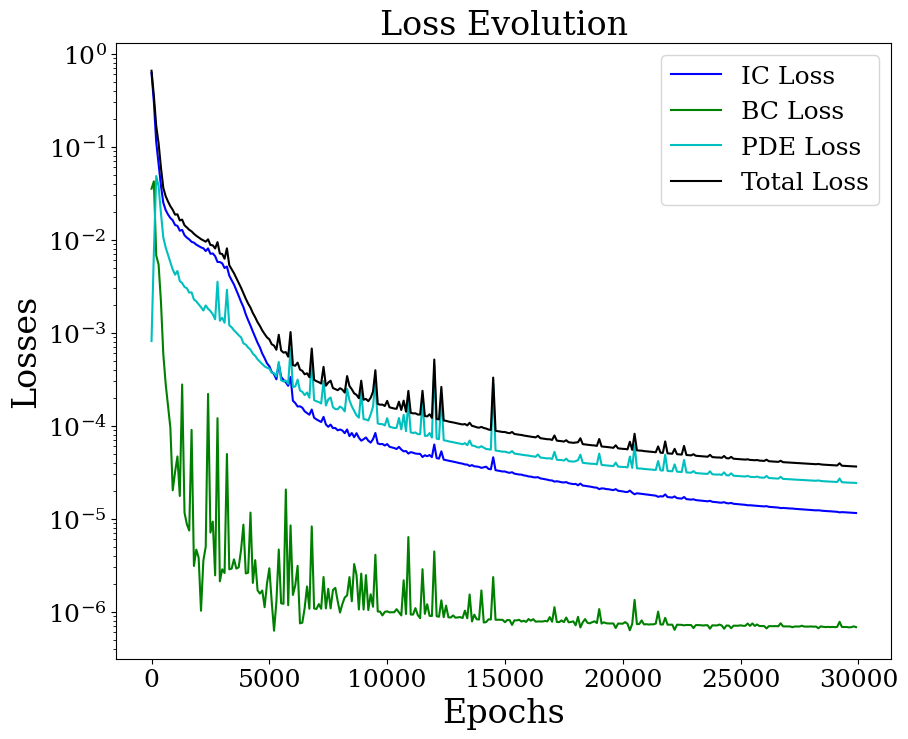

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.plot(Epoch, IC_Loss, "b-",label = "IC Loss")
ax1.plot(Epoch, BC_Loss, "g-",label = "BC Loss")
ax1.plot(Epoch, PDE_Loss, "c-",label = "PDE Loss")
ax1.plot(Epoch, Total_Loss, "k-",label = "Total Loss")
ax1.set_xlabel('Epochs', fontsize=labelsize)
ax1.set_ylabel('Losses', fontsize=labelsize)
ax1.legend(loc=1, fontsize=ticksize)
ax1.set_yscale('log')
ax1.tick_params(axis='both', which='major', labelsize=ticksize)
plt.title("Loss Evolution", fontsize=labelsize)
# plt.savefig("burgers_pinn_loss.png", dpi=300, bbox_inches='tight')

Text(0, 0.5, '$u$')

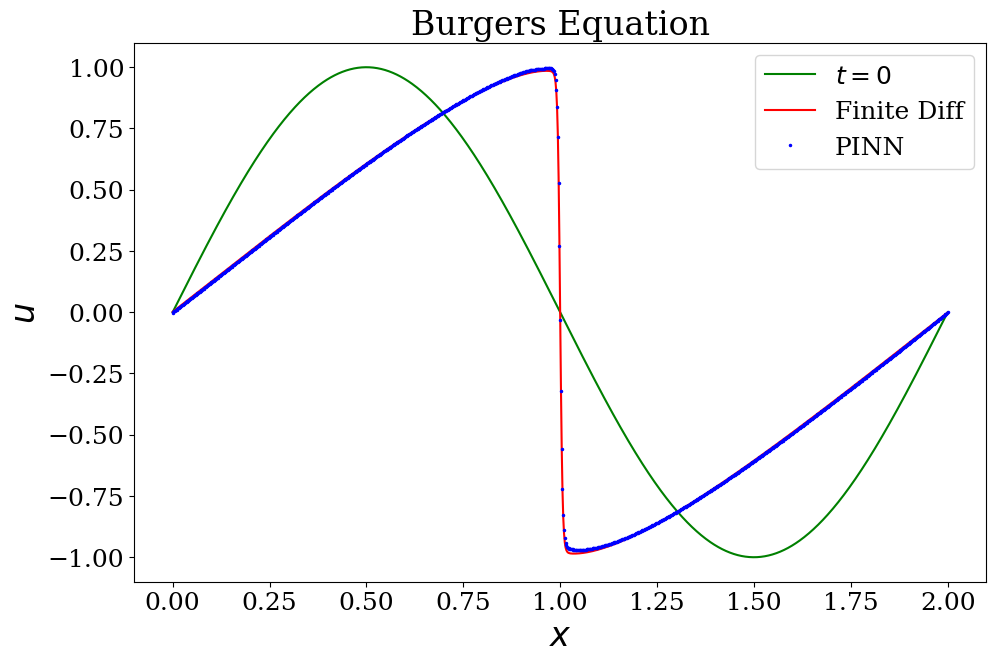

In [24]:
last_U_NN = u_NN_2D[:,-1].unsqueeze(1) #Extracting the last U values at t=0.48

fig, ax1 = plt.subplots(figsize=(11, 7), dpi= 100)

ax1.plot(x, u_init, "g",label="$t=0$")
ax1.plot(x, u_final, "r",label="Finite Diff", )
ax1.plot(x, last_U_NN.detach().cpu().numpy(), "bo",label="PINN", markersize=1.5)
ax1.legend(fontsize=ticksize)
plt.title("Burgers Equation", fontsize=labelsize)
ax1.tick_params(axis='both', which='major', labelsize=ticksize)
ax1.set_xlabel('$x$', fontsize=labelsize)
ax1.set_ylabel('$u$', fontsize=labelsize)
# plt.savefig("burgers_pinn_compare.png", dpi=300, bbox_inches='tight')